<a href="https://colab.research.google.com/github/wilberquito/Thesis/blob/main/Code/pytorch/notebooks/resnet18/ResNet18_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet18, V3

In [1]:
!pip install wandb >/dev/null 2>&1

In [2]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.8 MB/s eta 0:00:00
mlxtend version: 0.22.0


In [3]:
import requests
from pathlib import Path
import pandas as pd
import seaborn as sns
from zipfile import ZipFile

try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

Mounted at /content/drive
In colab: True


In [4]:
def pull_code():
  print("Unzipping the code from google drive")
  !rm -rf modular/
  !unzip ./drive/MyDrive/wilberquito_thesis/modular.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_code()

Unzipping the code from google drive


In [5]:
def pull_data():
  answer = input("You sure? Y/n\n")
  if answer != "Y":
    return

  print("Unzipping the data from google drive")
  !rm -rf data.etl/
  !unzip ./drive/MyDrive/wilberquito_thesis/data.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_data()

You sure? Y/n
Y
Unzipping the data from google drive


In [6]:
!nvidia-smi

Thu Jun 15 12:45:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Scheduler

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 20
T_0 = 5
T_MULT = 1
ETA_MIN = 1e-4

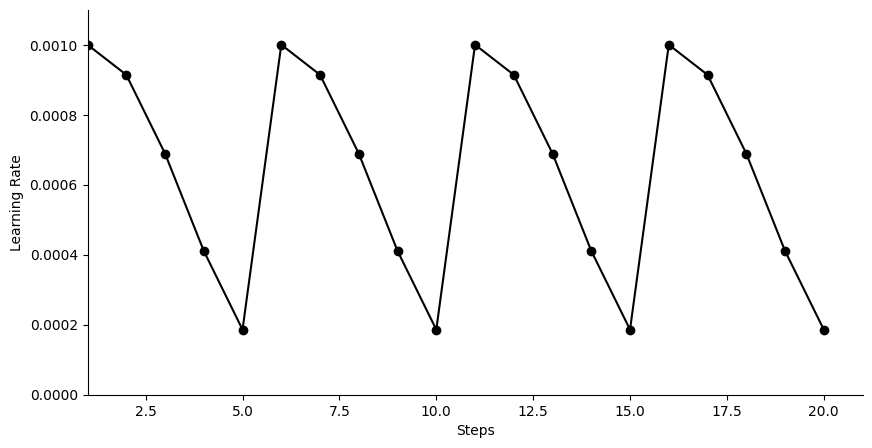

In [8]:
import torch
import torch.optim.lr_scheduler as lr_scheduler # Import your choice of scheduler here
import modular.utility as m_utility

import matplotlib.pyplot as plt

# Set model and optimizer
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Define your scheduler here as described above
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                     T_0 = T_0,# Number of iterations for the first restart
                                                     T_mult = T_MULT, # A factor increases TiTi​ after a restart
                                                     eta_min = ETA_MIN) # Minimum learning rate

m_utility.plot_learning_rate_scheduler(optimizer,
                                       scheduler,
                                       LEARNING_RATE,
                                       EPOCHS)

## Batch Size

In [9]:
BATCH_SIZE=400

## WandB

In [10]:
import wandb

key = "c1121fe51146c1da87d1139239da7748c4e78665"
wandb.login(key=key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [11]:
wandb.finish()

In [12]:
wandb.init(
    # set the wandb project where this run will be logged
    project="melanoma_thesis",
    group="train_test",
    name="ResNet18_V3",
    config={
      "architecture": "ResNet18",
      "scheduler": "CosineAnnealingWarmRestarts",
      "dataset": "ISIC",
      "learning_rate": LEARNING_RATE,
      "batch_size": BATCH_SIZE,
      "epochs": EPOCHS,
      "eta_min": ETA_MIN,
      "t_0": T_0,
      "t_mult": T_MULT
    }
)

wandb: Currently logged in as: wilberquto (wilberquito). Use `wandb login --relogin` to force relogin


## Writter

In [13]:
import modular.utility as m_utility

writter = m_utility.model_writter('resnet18_v3')

## Train

In [14]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.models import (ResNet18_Weights)
from torch.utils.data import DataLoader
import torch
import torchvision as tv
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.engine as engine
import modular.models as m_models

# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, test_df, mapping = m_dataset.get_df(data_dir, data_folder)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

out_features = len(mapping)
model = m_models.ResNet18_Melanoma(out_features)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                     T_0 = T_0,# Number of iterations for the first restart
                                                     T_mult = T_MULT, # A factor increases TiTi​ after a restart
                                                     eta_min = ETA_MIN) # Minimum learning rat

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

# Train and validate dataset & dataloader
train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.2)

validate_df, test_df = m_dataset.train_validate_split(validate_df,
                                                      random_state=42,
                                                      validate_size=0.5)


train_transforms, val_transforms = m_dataset.get_transforms(image_size=256)
train_transforms = val_transforms

train_dataset = m_dataset.MelanomaDataset(train_df,
                                          mode='train',
                                          transforms=train_transforms,
                                          idx_to_class=idx_to_class)
validate_dataset = m_dataset.MelanomaDataset(validate_df,
                                             mode='validate',
                                             transforms=val_transforms,
                                             idx_to_class=idx_to_class)

batch_size = BATCH_SIZE

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

# Test dataset and dataloader
test_dataset = m_dataset.MelanomaDataset(test_df,
                                         mode='test',
                                         idx_to_class=idx_to_class)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Dataloaders
dataloaders = {
    'train': train_dataloader,
    'val': validate_dataloader,
}

datasets_size = {
    'train': len(train_dataset),
    'val': len(validate_dataset),
}

about_data = {
    'dataloaders': dataloaders,
    'datasets': {
        'size': datasets_size
    }
}

MEL_IDX = 6 # Check data exploration notebook
VAL_TIMES = 4

model_ft, stats = engine.train_model(model,
                                     MEL_IDX,
                                     about_data,
                                     device,
                                     criterion,
                                     optimizer,
                                     scheduler,
                                     num_epochs=EPOCHS,
                                     writter=writter,
                                     val_times=VAL_TIMES)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1765: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


Epoch 1/20
----------
Train OvR: 0.8475 	|	Train Loss: 1.1262 	|	Train Acc: 0.6269
Val OvR: 0.8483 	|	Val Loss: 0.9220 	|	Val Acc: 0.6734
=> Saving a new checkpoint
Epoch 2/20
----------
Train OvR: 0.8717 	|	Train Loss: 0.8645 	|	Train Acc: 0.6981
Val OvR: 0.8724 	|	Val Loss: 0.8452 	|	Val Acc: 0.6955
=> Saving a new checkpoint
Epoch 3/20
----------
Train OvR: 0.8802 	|	Train Loss: 0.8022 	|	Train Acc: 0.7166
Val OvR: 0.8802 	|	Val Loss: 0.8172 	|	Val Acc: 0.7057
=> Saving a new checkpoint
Epoch 4/20
----------
Train OvR: 0.8392 	|	Train Loss: 0.7692 	|	Train Acc: 0.7279
Val OvR: 0.8841 	|	Val Loss: 0.7984 	|	Val Acc: 0.7137
=> Saving a new checkpoint
Epoch 5/20
----------
Train OvR: 0.8604 	|	Train Loss: 0.7516 	|	Train Acc: 0.7339
Val OvR: 0.8836 	|	Val Loss: 0.7924 	|	Val Acc: 0.7140
=> Saving a new checkpoint
Epoch 6/20
----------
Train OvR: 0.8622 	|	Train Loss: 0.7330 	|	Train Acc: 0.7412
Val OvR: 0.8892 	|	Val Loss: 0.7635 	|	Val Acc: 0.7230
=> Saving a new checkpoint
Epoch 7/20

In [15]:
wandb.finish()

train_acc,▁▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
train_loss,█▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
train_ovr,▁▃▃▁▂▂▅▃▄▄▃▅▅▆▇▆▅▅▆█
val_acc,▁▃▃▄▄▅▅▆▅▆▆▇▇▇▇▇████
val_loss,█▆▅▅▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_ovr,▁▄▄▅▅▅▆▆▇▇▇▇▇▇▇▇████
train_acc,0.8607
train_loss,0.4155
train_ovr,0.9906
val_acc,0.7671
val_loss,0.6432


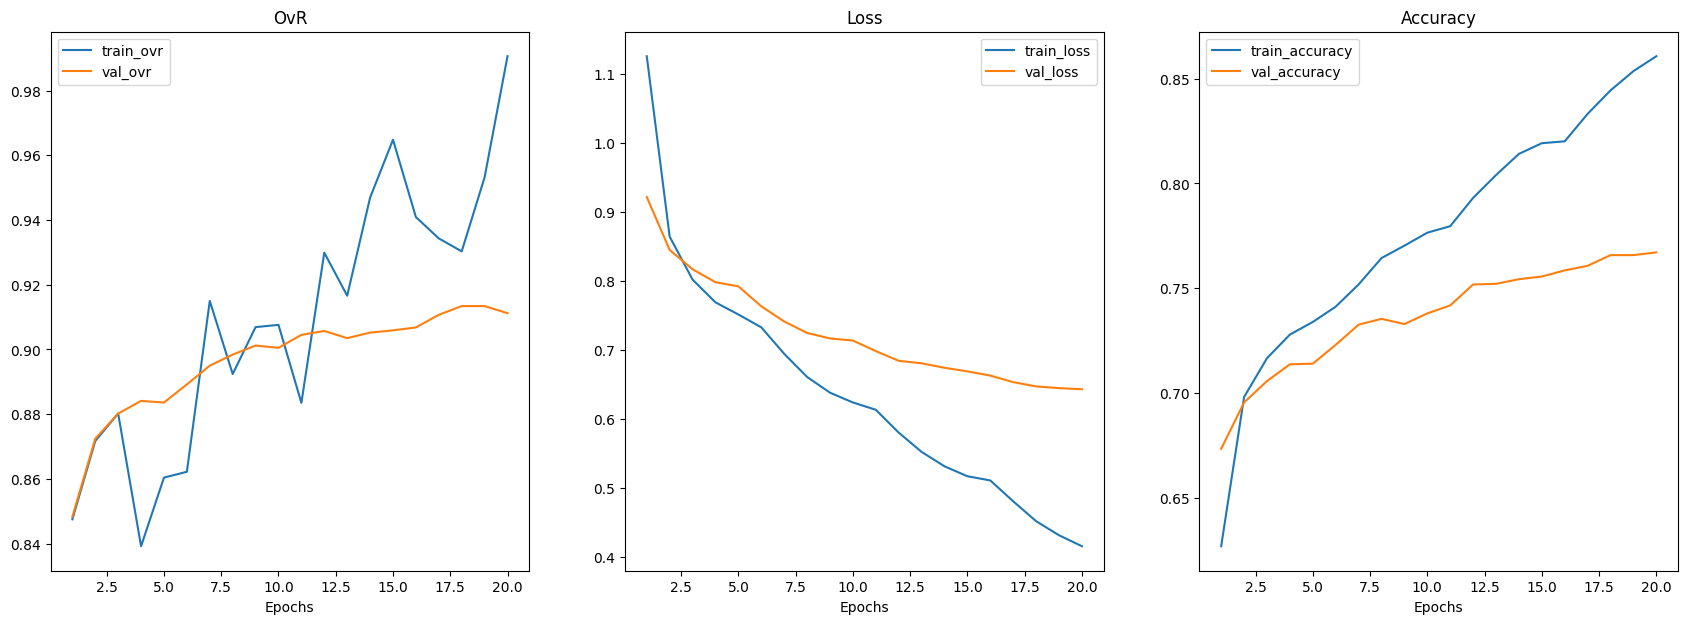

In [16]:
m_utility.plot_curves(stats)

In [17]:
if IN_COLAB:
  from google.colab import files
  files.download('resnet18_v3.pth.tar')
  files.download('resnet18_v3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>